In [1]:
import time
import sys, os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
import scipy.stats
import tracemalloc
import umap
import hdbscan
import logging
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import make_scorer
logging.captureWarnings(True)
# for Linux only, load font file
# mpl.font_manager.fontManager.addfont("./arial.ttf")

# configure matplotlib
# mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
np.random.seed(55)

In [2]:
def show_logos_cols(prefix, names=None, cols=3, figsize=(8,8), auto_size=True):
    file_list = []
    for img in os.listdir(prefix):
        if img.endswith(".png") == False:
            continue
        if names is not None and fn not in names:
            continue
        file_list.append(img)
    
    file_list_format = []
    for i in file_list:
        try:
            id = int(i.replace("cluster_", "").replace(".png", ""))
        except ValueError:
            id = i.replace("cluster_", "").replace(".png", "")
        file_list_format.append((i, id))
    file_list_format = sorted(file_list_format, key=lambda x:x[1]) 
    
    if len(file_list_format) % cols == 0:
        rows = len(file_list_format) // cols
    else:
        rows = len(file_list_format) // cols + 1
    if auto_size == False:
        figsize = figsize
    else:
        width = 4 * cols
        height = 1.5 * rows
        figsize = (width, height)
    
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    if len(file_list_format) > 1:
        for ax, image in zip(*[axes.reshape(-1), file_list_format]):
            fn, id = image
            img = plt.imread(prefix+"/"+fn)
            _ = ax.imshow(img)
            ax.set_title("{}".format(id))
        for ax in axes.reshape(-1):
            ax.axis("off")
    else:
        image = file_list_format[0]
        fn, id = image
        img = plt.imread(prefix+"/"+fn)
        _ = axes.imshow(img)
        axes.set_title("{}".format(id))
        axes.axis("off")
    plt.tight_layout()

In [3]:
def draw_one_sample(ax, df, title=None, cluster_col="Cluster", s=0.2, alpha=1.0):
    clusters = list([i for i in range(1, int(df[cluster_col].max())+1)]) + [-1]
    
    for i in clusters:
        subdf = df[df[cluster_col]==i]
        if i == -1:
            ax.scatter(subdf["X"], subdf["Y"], s=s, alpha=alpha, c="lightgray", lw=None, label=i)
        else:
            ax.scatter(subdf["X"], subdf["Y"], s=s, alpha=alpha, lw=None, label=i)
            c_X = subdf["X"].mean()
            c_Y = subdf["Y"].mean()
            ax.annotate("{}".format(i), xy=(c_X, c_Y), color="k", ha="center", va="center", size=9) # , size=13

    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()

    # draw density
    xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([df["X"], df["Y"]])
    kernel = scipy.stats.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)
    c = ax.contour(xx, yy, f, linewidths=0.5, colors="k")

    ax.set_xlabel("UMAP-1")
    ax.set_ylabel("UMAP-2")
    ax.set_title(title)
    # ax.xaxis.set_major_locator(ticker.MultipleLocator(3))
    # ax.yaxis.set_major_locator(ticker.MultipleLocator(3))
    return xmin, xmax, ymin, ymax

In [4]:
def extract_fasta_and_draw_motifs(prefix, df, cluster_col="Cluster", filter=None, motif_column="motif_F10", draw_logos=True):
    print("===============  {} ===============".format(prefix))
    if os.path.isdir("{}".format(prefix)) == False:
        os.mkdir("./{}".format(prefix))
        os.mkdir("./{}/fasta".format(prefix))
        os.mkdir("./{}/logos_bits".format(prefix))
        os.mkdir("./{}/logos_bits_no_axis".format(prefix))
        os.mkdir("./{}/logos_freq".format(prefix))
        os.mkdir("./{}/logos_freq_png".format(prefix))
        os.mkdir("./{}/logos_bits_png".format(prefix))
    else:
        os.system("rm -r ./{}/*".format(prefix))
        os.mkdir("./{}/fasta".format(prefix))
        os.mkdir("./{}/logos_bits".format(prefix))
        os.mkdir("./{}/logos_bits_no_axis".format(prefix))
        os.mkdir("./{}/logos_freq".format(prefix))
        os.mkdir("./{}/logos_freq_png".format(prefix))
        os.mkdir("./{}/logos_bits_png".format(prefix))
    if filter is not None:
        df = df[df[filter] == True].copy()
    clusters = set(df[cluster_col].tolist())
    for g in clusters:
        subdf = df[df[cluster_col] == g]
        with open("./{}/fasta/cluster_{}.fa".format(prefix, g), "w") as output:
            N = 0
            for idx, row in subdf.iterrows():
                output.write(">{}\n{}\n".format(idx, row[motif_column]))  # to RNA bases .replace("T", "U")
                N += 1
            print("Cluster #{}: {}".format(g, N))
    if draw_logos == True:
        for g in clusters:
            os.system("weblogo -A dna -D fasta -F pdf --resolution 1000 --color-scheme classic --composition none -i 0 -P \"\" -f ./{prefix}/fasta/cluster_{g}.fa -o ./{prefix}/logos_bits/cluster_{g}.pdf".format(prefix=prefix, g=g))
            
            os.system("weblogo -A dna -D fasta -F png --resolution 1000 --color-scheme classic --composition none -i 0 -P \"\" -f ./{prefix}/fasta/cluster_{g}.fa -o ./{prefix}/logos_bits_png/cluster_{g}.png".format(prefix=prefix, g=g))

            os.system("weblogo -A dna -D fasta -F pdf -y Frequency --resolution 1000 --color-scheme classic --units probability --composition none -i 0 -P \"\" -f ./{prefix}/fasta/cluster_{g}.fa -o ./{prefix}/logos_freq/cluster_{g}.pdf".format(prefix=prefix, g=g))
            
            os.system("weblogo -A dna -D fasta -F png -y Frequency --resolution 1000 --color-scheme classic --units probability --composition none -i 0 -P \"\" -f ./{prefix}/fasta/cluster_{g}.fa -o ./{prefix}/logos_freq_png/cluster_{g}.png".format(prefix=prefix, g=g)) 
            
            os.system("weblogo -A dna -D fasta -X no -Y no -P \"\" -F pdf --resolution 1000 --color-scheme classic --composition none -i 0 -f ./{prefix}/fasta/cluster_{g}.fa -o ./{prefix}/logos_bits_no_axis/cluster_{g}.pdf".format(prefix=prefix, g=g))

In [11]:
df_UMAP = pd.read_csv("./master/Sim_UMAP.csv")
df_UMAP["TF"] = df_UMAP["info"].str.split("_", expand = True)[0]
df_UMAP.head()

,Unnamed: 0,info,F10,X,Y,TF
0,0,CEBPB_0,ACACAATATTACACCATGTGG,-0.127826,8.676907,CEBPB
1,1,CEBPB_1,GCTAAACATTGCGTAATGCTT,-0.913635,8.184670,CEBPB
2,2,CEBPB_2,TCCGTATGTTGCACAATCTTG,-0.958484,8.351378,CEBPB
3,3,CEBPB_3,AATCCATATTGCATCAGCTAG,0.041990,8.595021,CEBPB
4,4,CEBPB_4,CCCTCGGGTTTCCCAATCGCA,-0.948835,8.371084,CEBPB


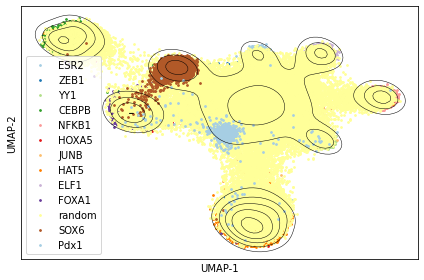

In [12]:
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=sns.color_palette("Paired")) 

fig, ax = plt.subplots()
for TF in set(df_UMAP["TF"].tolist()):
    if TF != "random_noise":
        subdf = df_UMAP[df_UMAP["TF"] == TF]
        ax.scatter(subdf["X"], subdf["Y"], s=3, label=TF)
    else:
        subdf = df_UMAP[df_UMAP["TF"] == TF]
        ax.scatter(subdf["X"], subdf["Y"], s=3, label=TF, zorder=0, color="lightgray")
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([df_UMAP["X"], df_UMAP["Y"]])
kernel = scipy.stats.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)
c = ax.contour(xx, yy, f, linewidths=0.5, colors="k")
    
ax.set_xlabel("UMAP-1")
ax.set_ylabel("UMAP-2")
ax.set_xticks([])
ax.set_yticks([])
plt.tight_layout()
plt.savefig("UMAP.jpg", dpi=300)
plt.legend()
plt.savefig("UMAP.legend.jpg", dpi=300)

In [13]:
df_HDBSCAN = pd.read_csv("./simulate_F10.tsv", sep = "\t")
df_HDBSCAN["TF"] = df_HDBSCAN["info"].str.split("_", expand = True)[0]
df_HDBSCAN.head()

,info,F10,X,Y,Cluster,TF
0,CEBPB_0,ACACAATATTACACCATGTGG,-0.127826,8.676907,1,CEBPB
1,CEBPB_1,GCTAAACATTGCGTAATGCTT,-0.913635,8.184670,1,CEBPB
2,CEBPB_2,TCCGTATGTTGCACAATCTTG,-0.958484,8.351378,1,CEBPB
3,CEBPB_3,AATCCATATTGCATCAGCTAG,0.041990,8.595021,1,CEBPB
4,CEBPB_4,CCCTCGGGTTTCCCAATCGCA,-0.948835,8.371084,1,CEBPB


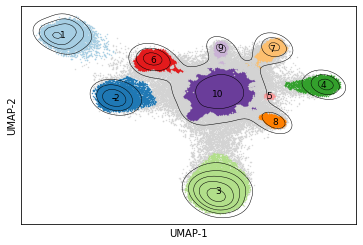

In [14]:
fig, ax = plt.subplots()
draw_one_sample(ax, df_HDBSCAN, title=None, cluster_col="Cluster")
ax.set_xticks([])
ax.set_yticks([])
plt.savefig("iMVP_out.jpg", dpi=300)

In [15]:
extract_fasta_and_draw_motifs("iMVP_out", df_HDBSCAN, motif_column="F10")

===============  iMVP_out ===============
Cluster #1: 13384
Cluster #2: 10657
Cluster #3: 25109
Cluster #4: 7134
Cluster #5: 410
Cluster #6: 8022
Cluster #7: 6187
Cluster #8: 4168
Cluster #9: 3006
Cluster #10: 16563
Cluster #-1: 15210


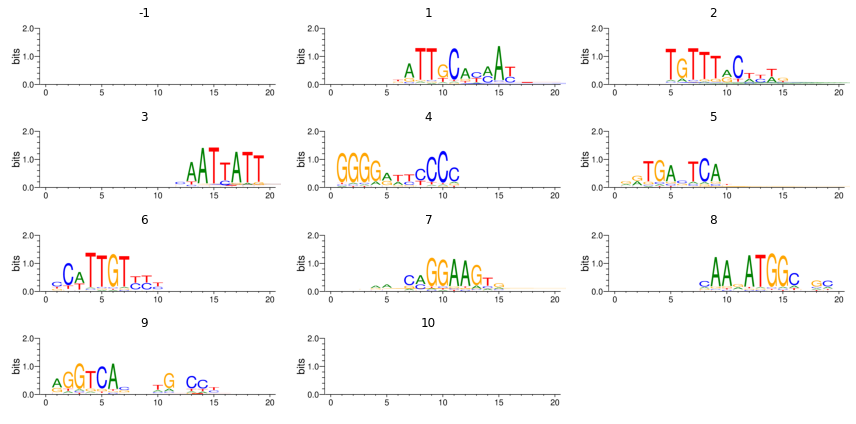

In [16]:
show_logos_cols("./iMVP_out/logos_bits_png/")

In [ ]:
extract_fasta_and_draw_motifs("iMVP_out_ground_truth", df_HDBSCAN, cluster_col="TF")

===============  iMVP_out_ground_truth ===============
Cluster #CDX2: 20000
Cluster #YY1: 10000
Cluster #FOXA1: 8000
Cluster #SOX6: 6000
Cluster #random_noise: 50000
Cluster #HOXA5: 5000
Cluster #ZEB1: 4000
Cluster #Pdx1: 3000
Cluster #JUNB: 2000
Cluster #ESR2: 1000
Cluster #CEBPB: 500
Cluster #ELF1: 250
Cluster #NFKB1: 100


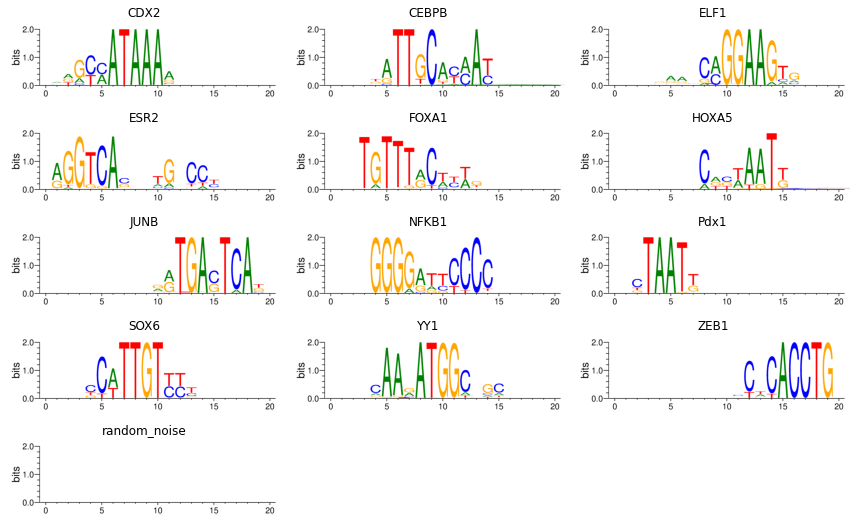

In [ ]:
show_logos_cols("./iMVP_out_ground_truth/logos_bits_png/")

## HDBSCAN (not softclustering)

HDBSCAN soft clustering time: 18.21119737625122 sec
HDBSCAN soft clustering RAM: 0.0 Mb
HDBSCAN cluster number: 18
Cluster
1     13281
2      8429
3     11435
4      9069
5      7078
6      4189
7      5358
8      1950
9      2496
10     1018
11     6117
12     4134
13     6705
14     4776
15     3076
16     6637
17     5481
18     8621
Name: Cluster, dtype: int64


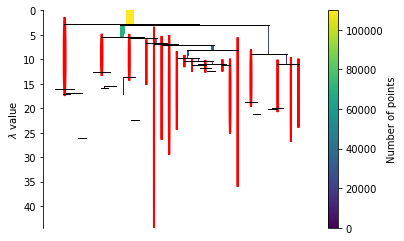

In [ ]:
_, _, df_HDBSCAN_soft, _ = cluster_HDBSCAN(df_UMAP, min_cluster_size=100, min_samples=100, soft_clustering=True, optimize=False)

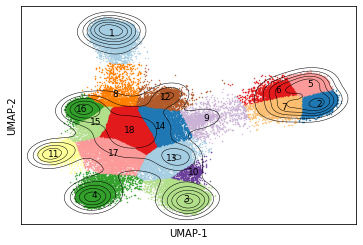

In [ ]:
fig, ax = plt.subplots()
draw_one_sample(ax, df_HDBSCAN_soft, title=None, cluster_col="Cluster")
ax.set_xticks([])
ax.set_yticks([])
plt.savefig("iMVP_out.soft.jpg", dpi=300)

In [ ]:
extract_fasta_and_draw_motifs("iMVP_out_soft", df_HDBSCAN_soft)

===============  iMVP_out_soft ===============
Cluster #1: 13281
Cluster #2: 8429
Cluster #3: 11435
Cluster #4: 9069
Cluster #5: 7078
Cluster #6: 4189
Cluster #7: 5358
Cluster #8: 1950
Cluster #9: 2496
Cluster #10: 1018
Cluster #11: 6117
Cluster #12: 4134
Cluster #13: 6705
Cluster #14: 4776
Cluster #15: 3076
Cluster #16: 6637
Cluster #17: 5481
Cluster #18: 8621


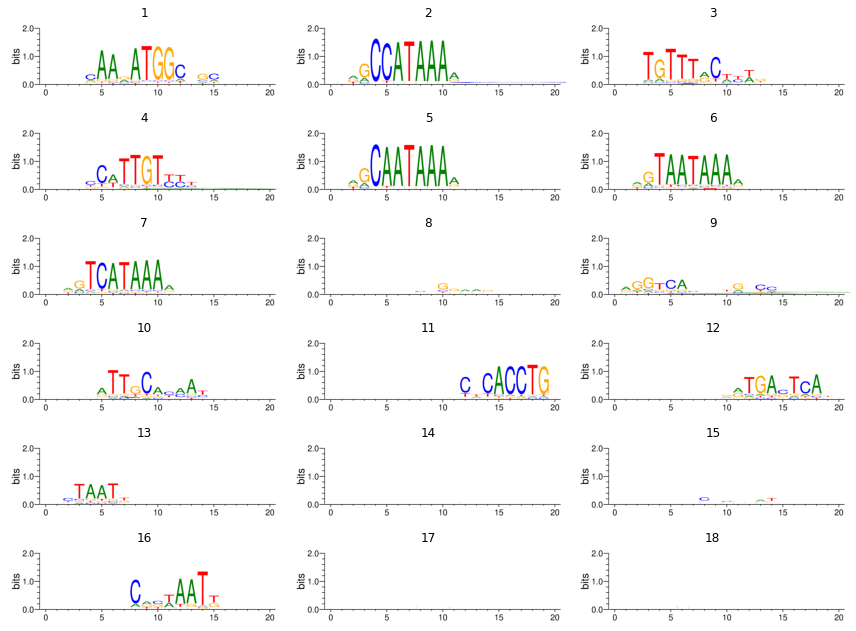

In [ ]:
show_logos_cols("./iMVP_out_soft/logos_bits_png/")

## Leiden

In [ ]:
from umap.umap_ import nearest_neighbors
from scipy.sparse import issparse, coo_matrix, csr_matrix
# leiden
import leidenalg
import igraph as ig

In [ ]:
def get_sparse_matrix_from_indices_distances_umap(
        knn_indices, knn_dists, n_obs, n_neighbors
    ):
    from scipy.sparse import issparse, coo_matrix, csr_matrix
    rows = np.zeros((n_obs * n_neighbors), dtype=np.int64)
    cols = np.zeros((n_obs * n_neighbors), dtype=np.int64)
    vals = np.zeros((n_obs * n_neighbors), dtype=np.float64)

    for i in range(knn_indices.shape[0]):
        for j in range(n_neighbors):
            if knn_indices[i, j] == -1:
                continue  # We didn't get the full knn for i
            if knn_indices[i, j] == i:
                val = 0.0
            else:
                val = knn_dists[i, j]

            rows[i * n_neighbors + j] = i
            cols[i * n_neighbors + j] = knn_indices[i, j]
            vals[i * n_neighbors + j] = val

    result = coo_matrix((vals, (rows, cols)), shape=(n_obs, n_obs))
    result.eliminate_zeros()
    return result.tocsr()

def compute_connectivities_umap(
        knn_indices,
        knn_dists,
        n_obs,
        n_neighbors,
        set_op_mix_ratio=1.0,
        local_connectivity=1.0,
    ):
    from scipy.sparse import issparse, coo_matrix, csr_matrix
    from umap.umap_ import fuzzy_simplicial_set
    X = coo_matrix(([], ([], [])), shape=(n_obs, 1))
    connectivities = fuzzy_simplicial_set(
        X,
        n_neighbors,
        None,
        None,
        knn_indices=knn_indices,
        knn_dists=knn_dists,
        set_op_mix_ratio=set_op_mix_ratio,
        local_connectivity=local_connectivity,
    )

    if isinstance(connectivities, tuple):
        # In umap-learn 0.4, this returns (result, sigmas, rhos)
        connectivities = connectivities[0]

    distances = get_sparse_matrix_from_indices_distances_umap(
        knn_indices, knn_dists, n_obs, n_neighbors
    )

    return distances, connectivities.tocsr()

def get_igraph_from_adjacency(adjacency, directed=None):
    """Get igraph graph from adjacency matrix."""
    sources, targets = adjacency.nonzero()
    weights = adjacency[sources, targets]
    if isinstance(weights, np.matrix):
        weights = weights.A1
    g = ig.Graph(directed=directed)
    g.add_vertices(adjacency.shape[0])  # this adds adjacency.shape[0] vertices
    g.add_edges(list(zip(sources, targets)))
    try:
        g.es['weight'] = weights
    except KeyError:
        pass
    return g

def get_igraph(onehot_input, random_state = 42, metric="euclidean", n_neighbors = 20, metric_kwds={}, angular=False, verbose=False):
    time0 = time.time()
    n_obs = onehot_input.shape[0]
    
    knn_indices, knn_dists, forest = nearest_neighbors(
            onehot_input,
            n_neighbors,
            random_state=random_state,
            metric=metric,
            metric_kwds=metric_kwds,
            angular=angular,
            verbose=verbose,
            n_jobs=4,
        )
      
    distances, connectivities = compute_connectivities_umap(knn_indices, knn_dists, n_obs, n_neighbors, set_op_mix_ratio=1.0, local_connectivity=1.0)
 
    g = get_igraph_from_adjacency(connectivities)
    return g, time.time() - time0

In [ ]:
def cluster_Leiden(df, graph, resolution_parameter=1):
    df = df.copy()
    tracemalloc.start()
    current, _ = tracemalloc.get_traced_memory()
    time0 = time.time()
    partition_type = leidenalg.RBConfigurationVertexPartition
    model = leidenalg.find_partition(graph, partition_type, seed=42, resolution_parameter=resolution_parameter)
    labels = model.membership
    
    time1 = time.time() - time0
    _, peak = tracemalloc.get_traced_memory()
    mem = (peak - current)/1024./1024.
    tracemalloc.stop()
    print("Louvain time: {} sec".format(time1))
    print("Louvain RAM: {} Mb".format(mem))
    print("==================================================")
    print()
    
    df["Cluster"] = labels
    df["Cluster"] += 1
    return time1, mem, df

In [ ]:
g, time_graph = get_igraph(onehot_input)

In [ ]:
t1, m1, df_leiden = cluster_Leiden(df_UMAP, g)

Louvain time: 10.679689645767212 sec
Louvain RAM: 4.603525161743164 Mb



In [ ]:
def draw_one_sample2(ax, df, title=None, cluster_col="Cluster", s=0.2, alpha=1.0, init=1):
    clusters = list([i for i in range(init, int(df[cluster_col].max())+1)]) + [-1]
    print(clusters)
    for i in clusters:
        subdf = df[df[cluster_col]==i]
        print(subdf.shape)
        if i == -1:
            ax.scatter(subdf["X"], subdf["Y"], s=s, alpha=alpha, c="lightgray", lw=None, label=i)
        else:
            ax.scatter(subdf["X"], subdf["Y"], s=s, alpha=alpha, lw=None, label=i)
            c_X = subdf["X"].mean()
            c_Y = subdf["Y"].mean()
            ax.annotate("{}".format(i), xy=(c_X, c_Y), color="k", ha="center", va="center", size=9) # , size=13

    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()

    # draw density
    xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([df["X"], df["Y"]])
    kernel = scipy.stats.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)
    c = ax.contour(xx, yy, f, linewidths=0.5, colors="k")

    ax.set_xlabel("UMAP-1")
    ax.set_ylabel("UMAP-2")
    ax.set_title(title)
    # ax.xaxis.set_major_locator(ticker.MultipleLocator(3))
    # ax.yaxis.set_major_locator(ticker.MultipleLocator(3))
    return xmin, xmax, ymin, ymax

[0, 1, 2, 3, 4, 5, 6, 7, 8, -1]
(0, 5)
(27618, 5)
(15288, 5)
(14261, 5)
(13932, 5)
(13344, 5)
(10908, 5)
(7739, 5)
(6760, 5)
(0, 5)


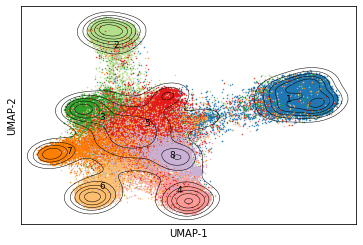

In [ ]:
# mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=sns.color_palette("Paired")) 
fig, ax = plt.subplots()

draw_one_sample2(ax, df_leiden, title=None, cluster_col="Cluster", init=0)
ax.set_xticks([])
ax.set_yticks([])
plt.savefig("iMVP_out.leiden.jpg", dpi=300)

In [ ]:
extract_fasta_and_draw_motifs("iMVP_out_leiden", df_leiden, cluster_col="Cluster")

===============  iMVP_out_leiden ===============
Cluster #1: 27618
Cluster #2: 15288
Cluster #3: 14261
Cluster #4: 13932
Cluster #5: 13344
Cluster #6: 10908
Cluster #7: 7739
Cluster #8: 6760


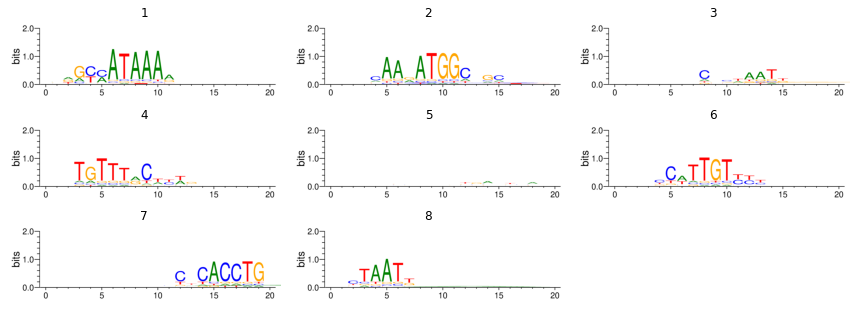

In [ ]:
show_logos_cols("./iMVP_out_leiden/logos_bits_png/")